In [1]:
# General imports
import os
import sys
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)
import scipy

pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import subprocess

from sklearn.cluster import KMeans

from tqdm import tqdm
# Other imports
tqdm.pandas()

import json

from pprint import pprint

# Custom utils
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from utils.utils import load_config_file

# Figures imports
import matplotlib

from matplotlib.lines import Line2D   
import matplotlib.patches as mpatches

import random 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statannot import add_stat_annotation
import matplotlib.font_manager as font_manager
import string

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=60, progress_bar=True)

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/gene_isoforms/src/config/config_files.yaml")

dicts = json.load(open("/home/weber/PycharmProjects/EXOTIC/src/EXOTIC_config.json"))


# Font settings
font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 18


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


# Previous parts


# UTRs

In [10]:
utrs = pd.read_parquet(yaml["1_GENOMICS"]["Final"]["refseq_miso_utrs"])
genes_identical_cds = utrs.loc[utrs['Nb_combi'] == 1].Gene.values.tolist()

In [11]:
genes_path_processed = yaml['1_GENOMICS']['Final']['refseq_genes_processed_miso_siso']
genes = pd.read_parquet(genes_path_processed)
genes = genes.loc[~genes['Gene'].isin(genes_identical_cds)]

# Gene families

In [4]:
hgnc = pd.read_csv('/gstock/EXOTIC/data/HGNC/gene_with_protein_product.txt', sep='\t')
hgnc.columns
# hgnc

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (31,38,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['hgnc_id', 'symbol', 'name', 'locus_group', 'locus_type', 'status',
       'location', 'location_sortable', 'alias_symbol', 'alias_name',
       'prev_symbol', 'prev_name', 'gene_family', 'gene_family_id',
       'date_approved_reserved', 'date_symbol_changed', 'date_name_changed',
       'date_modified', 'entrez_id', 'ensembl_gene_id', 'vega_id', 'ucsc_id',
       'ena', 'refseq_accession', 'ccds_id', 'uniprot_ids', 'pubmed_id',
       'mgd_id', 'rgd_id', 'lsdb', 'cosmic', 'omim_id', 'mirbase', 'homeodb',
       'snornabase', 'bioparadigms_slc', 'orphanet', 'pseudogene.org',
       'horde_id', 'merops', 'imgt', 'iuphar', 'kznf_gene_catalog',
       'mamit-trnadb', 'cd', 'lncrnadb', 'enzyme_id',
       'intermediate_filament_db', 'rna_central_ids', 'lncipedia', 'gtrnadb',
       'agr', 'mane_select'],
      dtype='object')

In [742]:
hgnc.loc[hgnc['gene_family'].isna() == True].shape

(5025, 53)

In [5]:
hgnc_lite = hgnc[['hgnc_id', 'symbol', 'name' , 'gene_family', 'gene_family_id']]
hgnc_lite['gene_family'] = hgnc_lite['gene_family'].str.split('|')
hgnc_lite = hgnc_lite.explode('gene_family')
hgnc_lite

,hgnc_id,symbol,name,gene_family,gene_family_id
0,HGNC:5,A1BG,alpha-1-B glycoprotein,Immunoglobulin like domain containing,594
1,HGNC:24086,A1CF,APOBEC1 complementation factor,RNA binding motif containing,725
2,HGNC:7,A2M,alpha-2-macroglobulin,"C3 and PZP like, alpha-2-macroglobulin domain ...",1234
3,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,"C3 and PZP like, alpha-2-macroglobulin domain ...",1234
4,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",Glycosyltransferase family 6,429
...,...,...,...,...,...
19193,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,Zinc fingers ZZ-type,91|863
19193,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,EF-hand domain containing,91|863
19194,HGNC:24523,ZZZ3,zinc finger ZZ-type containing 3,Zinc fingers ZZ-type,91|532|1058
19194,HGNC:24523,ZZZ3,zinc finger ZZ-type containing 3,Myb/SANT domain containing,91|532|1058


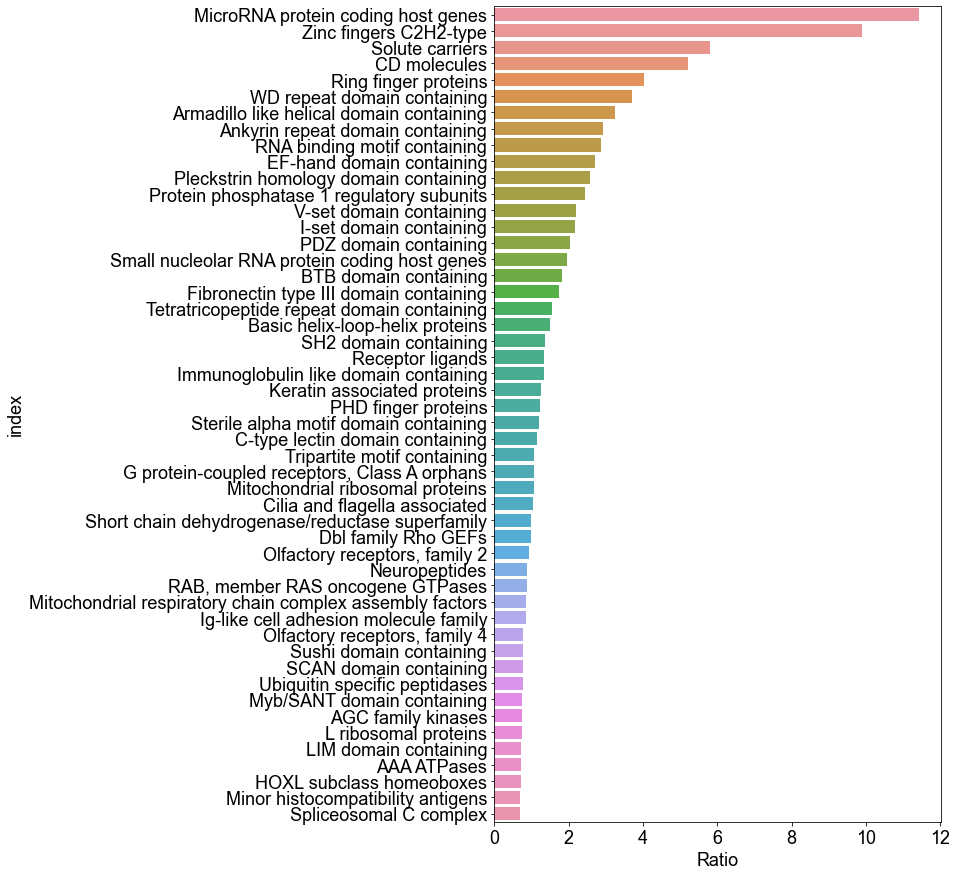

In [668]:
count_test = hgnc_lite.gene_family.value_counts().rename('count').reset_index()
count_test = count_test.loc[count_test['count'] > 50]
count_test['Ratio'] = 100 * (count_test['count'] / count_test['count'].sum())
f, ax = plt.subplots(figsize=(8,15))

sns.barplot(data=count_test, y='index', x='Ratio')

# plt.xticks(rotation=90)

In [16]:
hgnc_miso_siso = pd.merge(genes[['Gene', 'Miso_siso']], hgnc_lite.rename({'symbol' : 'Gene'}, axis=1), on ='Gene')
hgnc_miso_siso.dropna(subset=['gene_family'])['Miso_siso'].value_counts()
miso_siso_nb = hgnc_miso_siso.dropna(subset=['gene_family'])['Miso_siso'].value_counts()
fract_miso = miso_siso_nb['Miso'] / miso_siso_nb.sum()
fract_siso = miso_siso_nb['Siso'] / miso_siso_nb.sum()

In [14]:
hgnc_miso_siso = pd.merge(genes[['Gene', 'Miso_siso']], hgnc_lite.rename({'symbol' : 'Gene'}, axis=1), on ='Gene')
count = hgnc_miso_siso.groupby('gene_family')['Miso_siso'].value_counts().rename('count').reset_index()
# count = count.loc[count['gene_family'].isin(count_test['index'].tolist())]
count

# f, ax = plt.subplots(figsize=(8,30))

# sns.barplot(data=count, y='gene_family', hue='Miso_siso', x='count', palette=palette)

# plt.xticks(rotation=90)

,gene_family,Miso_siso,count
0,Mitochondrial translation release factor family,Miso,2
1,1-acylglycerol-3-phosphate O-acyltransferases,Miso,5
2,1-acylglycerol-3-phosphate O-acyltransferases,Siso,5
3,14-3-3 phospho-serine/phospho-threonine bindin...,Siso,5
4,3-hydroxyacyl-CoA dehydratase family,Miso,2
...,...,...,...
2328,tRNA splicing ligase complex,Miso,3
2329,tRNA-splicing endonuclease subunits,Miso,3
2330,tRNA-splicing endonuclease subunits,Siso,1
2331,tri-snRP complex,Miso,2


100%|██████████| 1325/1325 [00:00<00:00, 3766.81it/s]


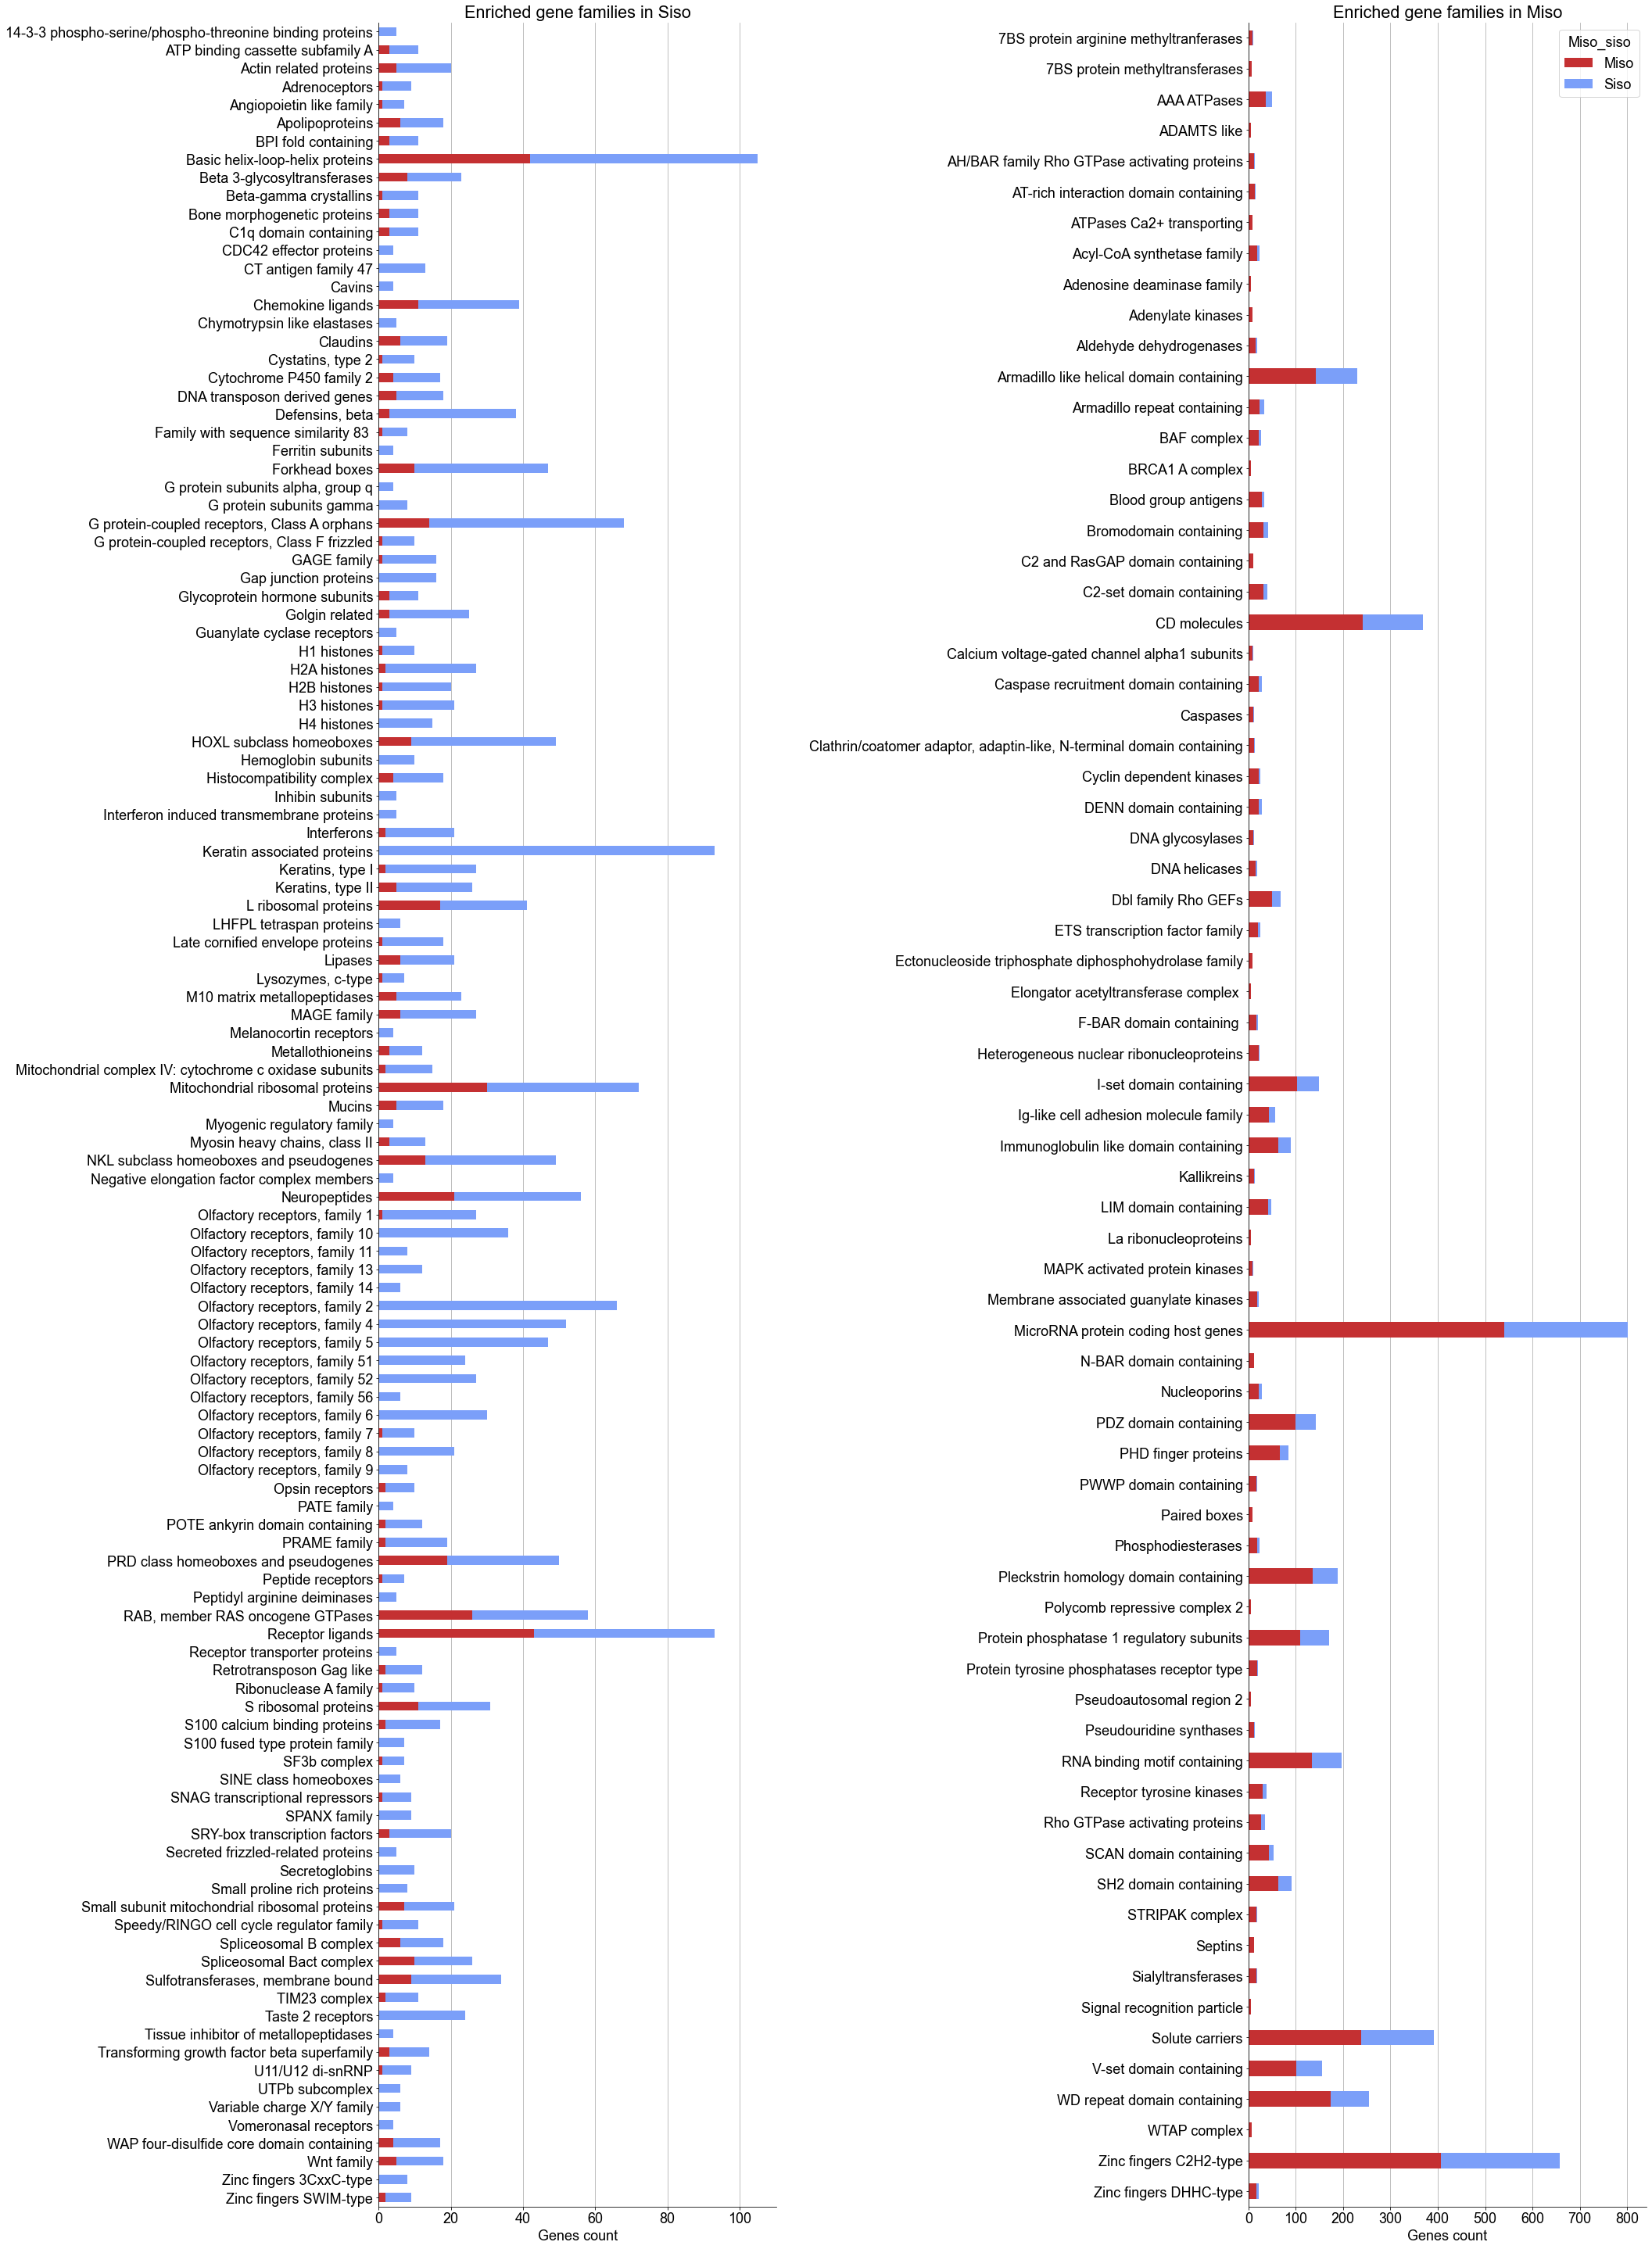

In [17]:
palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }


f, ax = plt.subplots(ncols=2, figsize=(30, 40))




count_stat = count.pivot(index='gene_family', columns='Miso_siso', values='count')
count_stat = count_stat.fillna(0)
count_stat['Total'] = count_stat.apply(sum, axis=1)
count_stat['binom_test'] = count_stat.progress_apply(lambda r: scipy.stats.binom_test(x=r['Siso'], n=r['Total'], p=fract_siso, alternative='greater'), axis=1)
count_stat = count_stat.loc[count_stat['binom_test']< 0.05]
count_stat['Diff'] = count_stat['Siso'] - count_stat['Miso']
count_stat = count_stat.sort_values(by='gene_family', ascending=False)


count_stat[['Miso', 'Siso']].plot(kind='barh', stacked=True, ax=ax[0], color=[palette['Miso'], palette['Siso']])
ax[0].legend().remove()
ax[0].set_title('Enriched gene families in Siso')

count_stat = count.pivot(index='gene_family', columns='Miso_siso', values='count')
count_stat = count_stat.fillna(0)
count_stat['Total'] = count_stat.apply(sum, axis=1)
count_stat['binom_test'] = count_stat.progress_apply(lambda r: scipy.stats.binom_test(x=r['Miso'], n=r['Total'], p=fract_miso, alternative='greater'), axis=1)
count_stat = count_stat.loc[count_stat['binom_test']< 0.05]
count_stat['Diff'] = count_stat['Siso'] - count_stat['Miso']
count_stat = count_stat.sort_values(by='gene_family', ascending=False)


count_stat[['Miso', 'Siso']].plot(kind='barh', stacked=True, ax=ax[1], color=[palette['Miso'], palette['Siso']])

ax[1].set_title('Enriched gene families in Miso')

plt.tight_layout()

for sub_ax in ax:
    sub_ax.spines['right'].set_linewidth(0)
    sub_ax.spines['top'].set_linewidth(0)
    sub_ax.set_ylabel('')
    sub_ax.grid(axis='x')
    sub_ax.set_axisbelow(True)
    sub_ax.set_xlabel('Genes count')

# # plt.xticks(rotation=90)